#  importing libraries

In [1]:
# IMPORT NECESSARY LIBRARIES
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import seaborn as sn
import numpy as np
from numpy import loadtxt
from keras.models import load_model
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import TensorBoard

import time


# Data Preprocessing

## Labeling Audio Files

In [2]:
# CREATE DIRECTORY OF AUDIO FILES 
audio = "C:/Users/21652/Desktop/jihed/Speech_Emotion_Recognition-master/Speech_Emotion_Recognition-master/Audio_Song_Actors_01-24"
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 
actor_folders[0:5]

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05']

In [3]:
# CREATE FUNCTION TO EXTRACT EMOTION NUMBER, ACTOR AND GENDER LABEL
emotion = []
gender = []
actor = []
file_path = []
for i in actor_folders:
    filename = os.listdir(audio +'/'+ i) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        actor.append(int(part[6]))
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append(audio+ '/' + i + '/' +f)

In [4]:
# PUT EXTRACTED LABELS WITH FILEPATH INTO DATAFRAME
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df = pd.concat([pd.DataFrame(gender),audio_df,pd.DataFrame(actor)],axis=1)
audio_df.columns = ['gender','emotion','actor']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
audio_df

,gender,emotion,actor,path
0,male,neutral,1,C:/Users/Jawher/Desktop/jihed/Speech_Emotion_R...
1,male,neutral,1,C:/Users/Jawher/Desktop/jihed/Speech_Emotion_R...
2,male,neutral,1,C:/Users/Jawher/Desktop/jihed/Speech_Emotion_R...
3,male,neutral,1,C:/Users/Jawher/Desktop/jihed/Speech_Emotion_R...
4,male,calm,1,C:/Users/Jawher/Desktop/jihed/Speech_Emotion_R...
...,...,...,...,...
1007,female,fear,24,C:/Users/Jawher/Desktop/jihed/Speech_Emotion_R...
1008,female,fear,24,C:/Users/Jawher/Desktop/jihed/Speech_Emotion_R...
1009,female,fear,24,C:/Users/Jawher/Desktop/jihed/Speech_Emotion_R...
1010,female,fear,24,C:/Users/Jawher/Desktop/jihed/Speech_Emotion_R...


In [5]:
# ENSURE GENDER,EMOTION, AND ACTOR COLUMN VALUES ARE CORRECT
pd.set_option('display.max_colwidth', -1)

audio_df.sample(10)

,gender,emotion,actor,path
583,female,calm,14,C:/Users/Jawher/Desktop/jihed/Speech_Emotion_Recognition-master/Speech_Emotion_Recognition-master/Audio_Song_Actors_01-24/Actor_14/03-02-02-02-02-02-14.wav
914,female,angry,22,C:/Users/Jawher/Desktop/jihed/Speech_Emotion_Recognition-master/Speech_Emotion_Recognition-master/Audio_Song_Actors_01-24/Actor_22/03-02-05-02-02-01-22.wav
356,male,calm,9,C:/Users/Jawher/Desktop/jihed/Speech_Emotion_Recognition-master/Speech_Emotion_Recognition-master/Audio_Song_Actors_01-24/Actor_09/03-02-02-01-01-01-09.wav
143,female,calm,4,C:/Users/Jawher/Desktop/jihed/Speech_Emotion_Recognition-master/Speech_Emotion_Recognition-master/Audio_Song_Actors_01-24/Actor_04/03-02-02-02-02-02-04.wav
377,male,sad,9,C:/Users/Jawher/Desktop/jihed/Speech_Emotion_Recognition-master/Speech_Emotion_Recognition-master/Audio_Song_Actors_01-24/Actor_09/03-02-04-02-01-02-09.wav
88,male,neutral,3,C:/Users/Jawher/Desktop/jihed/Speech_Emotion_Recognition-master/Speech_Emotion_Recognition-master/Audio_Song_Actors_01-24/Actor_03/03-02-01-01-01-01-03.wav
201,male,sad,5,C:/Users/Jawher/Desktop/jihed/Speech_Emotion_Recognition-master/Speech_Emotion_Recognition-master/Audio_Song_Actors_01-24/Actor_05/03-02-04-02-01-02-05.wav
872,male,fear,21,C:/Users/Jawher/Desktop/jihed/Speech_Emotion_Recognition-master/Speech_Emotion_Recognition-master/Audio_Song_Actors_01-24/Actor_21/03-02-06-01-01-01-21.wav
924,male,neutral,23,C:/Users/Jawher/Desktop/jihed/Speech_Emotion_Recognition-master/Speech_Emotion_Recognition-master/Audio_Song_Actors_01-24/Actor_23/03-02-01-01-01-01-23.wav
366,male,happy,9,C:/Users/Jawher/Desktop/jihed/Speech_Emotion_Recognition-master/Speech_Emotion_Recognition-master/Audio_Song_Actors_01-24/Actor_09/03-02-03-01-02-01-09.wav


<AxesSubplot:>

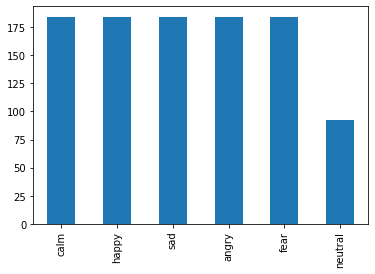

In [6]:
# LOOK AT DISTRIBUTION OF CLASSES
audio_df.emotion.value_counts().plot(kind='bar')

## Feature Extraction

In [7]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING 
df = pd.DataFrame(columns=['mel_spectrogram'])

counter=0

for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
        
    # Mel-frequency cepstral coefficients (MFCCs)
#     mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
#     mfcc=np.mean(mfcc,axis=0)
    
    # compute chroma energy (pertains to 12 different pitch classes)
#     chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
#     chroma = np.mean(chroma, axis = 0)

    # compute spectral contrast
#     contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
#     contrast = np.mean(contrast, axis= 0)

    # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at 
#     which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
#     zcr = librosa.feature.zero_crossing_rate(y=X)
#     zcr = np.mean(zcr, axis= 0)
    
    df.loc[counter] = [log_spectrogram]
    counter=counter+1   

print(len(df))
df.head()

1012


,mel_spectrogram
0,"[-70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -70.190216, -68.49858, -69.23745, -70.66261, -70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -70.67003, -69.54066, -66.911156, -67.440575, -70.47629, -70.67003, -70.67003, -70.628746, -59.254734, -43.85587, -40.168777, -41.190712, -43.157154, -44.008953, -40.533142, -37.10629, -34.757618, -32.68789, -31.242712, -30.120289, -29.687452, -29.560444, -28.877934, -29.341787, -30.94304, -33.464615, -38.88975, -43.080807, -45.807068, -46.199223, -45.987682, -44.60737, -42.585197, -41.126144, -38.51099, -35.71651, -32.96074, -31.02113, -29.765602, -28.952774, -28.531687, -27.539211, -26.62564, -26.87324, -27.474485, -28.6087, -29.16343, -28.684006, -27.88769, -27.964436, -30.570744, -35.62474, -40.347336, -43.384968, -45.963387, -43.16702, -34.02387, -32.436672, -34.492157, -33.694843, -33.73878, -33.381107, -33.560535, -34.43642, -33.960354, -33.16808, ...]"
1,"[-68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.248024, -68.04893, -60.11285, -45.350937, -42.00334, -41.741093, -41.91916, -43.271397, -43.133457, -37.824593, -34.305923, -31.937103, -30.453232, -29.497656, -28.785917, -28.187498, -28.061852, -27.69304, -26.917662, -27.700888, -27.459026, -28.016289, -31.628357, -37.958668, -40.81501, -42.368633, -43.840466, -43.424545, -42.202934, -40.88009, -39.053875, -35.384518, -30.63461, -27.908628, -26.501371, -26.061802, -27.090551, -26.300945, -25.959005, -26.737139, -26.107529, -25.980377, -27.159588, -27.926327, -28.559776, -28.601318, -28.349365, -28.043934, -27.009586, -30.559622, -36.29083, -38.025787, -41.260357, -43.106167, -35.34729, -33.36584, -36.46488, -35.779747, -35.02356, -35.06164, -33.27595, ...]"
2,"[-67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.80903, -67.798965, -67.38703, -67.21093, -67.03594, -49.46283, -39.598106, -34.318638, -31.077501, -30.176928, -28.498196, -28.264261, -28.873087, -28.981672, -28.520302, -27.99346, -28.29248, -28.153105, -28.301838, -28.545235, -29.830221, -29.78998, -30.552116, -33.21595, -36.99859, -41.46521, -43.18827, -42.553135, -36.735172, -33.153793, -32.836678, -33.406464, -32.764217, -29.826664, -27.830383, -28.27728, -28.424406, -28.546946, -28.41256, -28.114231, -29.045624, -29.830849, -30.05784, -29.242104, -28.03939, -27.667528, -28.419981, -28.537123, -29.107044, -29.651337, -30.34374, -31.182333, -31.939127, -32.60005, -33.40206, -34.381355, -35.294464, -35.175167, -34.42055, -33.495834, -34.229874, -29.979872, ...]"
3,"[-69.63423, -69.63423, -69.63423, -69.63423, -69.63423, -69.63423, -69.63423, -69.63423, -69.63423, -69.63423, -69.63423, -69.63423, -69.63423, -69.63423, -69.63423, -69.63423, -69.63423, -69.63423, -69.63423, -69.63423, -69.63423, -69.63423, -69.63423, -69.63423, -69.14961, -69.297646, -67.8701, -68.44447, -69.588104, -69.63423, -69.63423, -69.63423, -69.63423, -69.37452, -69.34724, -69.63423, -69.54584, -69.63423, -69.417465, -68.65891, -67.201614, -67.55465, -65.11445, -40.98

In [8]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING 
df1 = pd.DataFrame(columns=['mfcc'])

counter=0

for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
   # log_spectrogram = np.mean(db_spec, axis = 0)
        
    # Mel-frequency cepstral coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
    mfcc=np.mean(mfcc,axis=0)
    
    # compute chroma energy (pertains to 12 different pitch classes)
#     chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
#     chroma = np.mean(chroma, axis = 0)

    # compute spectral contrast
#     contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
#     contrast = np.mean(contrast, axis= 0)

    # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at 
#     which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
#     zcr = librosa.feature.zero_crossing_rate(y=X)
#     zcr = np.mean(zcr, axis= 0)
    
    df1.loc[counter] = [mfcc]
    counter=counter+1   

print(len(df1))
df1.head()

1012


,mfcc
0,"[-61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -62.151554, -62.328453, -63.07476, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.437893, -61.194283, -60.849426, -60.895798, -61.387733, -61.437893, -61.437893, -61.107216, -59.857037, -45.711346, -38.889267, -36.53251, -37.097466, -29.732597, -24.980236, -23.902977, -23.12183, -23.740465, -23.634695, -23.733448, -23.417091, -24.51813, -24.052935, -23.994926, -26.18621, -26.488516, -28.457066, -33.56494, -33.786774, -32.338387, -31.367708, -31.428806, -31.794638, -32.398094, -30.941545, -29.507961, -27.379284, -27.746504, -30.799679, -31.11086, -30.73749, -31.979618, -29.969563, -30.01867, -29.887747, -30.655132, -30.809042, -30.45988, -29.504639, -26.850895, -27.134636, -28.018301, -28.805264, -32.4379, -36.561344, -33.46091, -27.21954, -27.15051, -30.39628, -30.844906, -30.562675, -31.41053, -31.650465, -29.03514, -29.230604, -30.388216, ...]"
1,"[-59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -59.76821, -57.675797, -53.893414, -42.789917, -40.250244, -40.629208, -42.34266, -39.69204, -29.89987, -23.982357, -24.059319, -23.106676, -22.121826, -22.475166, -22.930696, -24.125347, -23.599743, -22.205025, -21.217861, -21.227793, -21.362333, -21.95323, -22.648094, -26.720402, -27.806334, -28.640095, -27.413597, -28.016174, -30.850197, -30.765919, -28.470877, -28.007437, -27.361217, -26.670559, -26.977987, -29.26652, -27.943869, -27.619408, -26.932304, -26.770905, -27.296904, -27.59283, -27.898813, -29.234978, -29.789806, -29.46861, -29.16602, -29.115984, -25.59075, -28.235512, -27.964903, -28.265759, -32.67519, -33.862663, -30.653385, -28.512505, -29.214296, -29.390547, -32.072197, -30.264906, -25.857182, ...]"
2,"[-59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.419876, -59.412888, -59.419876, -59.408348, -58.46498, -54.950474, -51.930233, -36.84047, -27.648485, -22.351257, -21.238243, -22.773388, -21.780539, -21.096355, -23.170208, -23.634373, -22.40959, -21.390171, -21.690147, -22.50355, -23.61407, -24.191704, -25.496609, -25.469908, -27.605389, -27.38091, -27.057125, -29.258772, -30.141937, -30.287708, -28.628237, -27.342588, -27.996609, -28.568132, -28.152191, -25.253448, -25.443441, -26.135363, -26.53722, -27.59862, -28.882204, -29.089651, -29.619854, -30.22004, -30.089996, -29.309004, -28.5656, -27.698202, -26.383314, -23.68207, -24.808628, -24.247831, -25.107601, -27.937117, -29.58547, -30.154179, -31.243727, -34.24955, -35.292553, -32.558823, -31.06132, -32.70069, -30.248348, -26.00769, ...]"
3,"[-61.265728, -61.265728, -61.265728, -61.265728, -61.265728, -61.265728, -61.265728, -61.265728, -61.265728, -61.265728, -61.265728, -61.265728, -61.265728, -61.265728, -61.265728, -61.265728, -61.265728, -61.265728, -61.265728, -61.265728, -61.265728, -61.265728, -61.265728, -61.265728, -58.9715, -59.314285, -58.802322, -59.354763, -60.654396, -61.265728, -61.265728, -61.265728, -61.265728, -61.116245, -61.062664, -61.265728, -60.01496, -61.

In [9]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING 
df4 = pd.DataFrame(columns=['zcr'])

counter=0

for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
   #spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    #db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
   # log_spectrogram = np.mean(db_spec, axis = 0)
        
    # Mel-frequency cepstral coefficients (MFCCs)
    #mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
   # mfcc=np.mean(mfcc,axis=0)
    
    # compute chroma energy (pertains to 12 different pitch classes)
   # chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
    #chroma = np.mean(chroma, axis = 0)

    # compute spectral contrast
   # contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
    ##contrast = np.mean(contrast, axis= 0)

    # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at 
      #which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
    zcr = librosa.feature.zero_crossing_rate(y=X)
    zcr = np.mean(zcr, axis= 0)
    
    df4.loc[counter] = [zcr]
    counter=counter+1   

print(len(df4))
df4.head()

1012


,zcr
0,"[0.0458984375, 0.0458984375, 0.0458984375, 0.0361328125, 0.0, 0.0, 0.01171875, 0.0400390625, 0.0576171875, 0.0576171875, 0.0458984375, 0.017578125, 0.0126953125, 0.0126953125, 0.0126953125, 0.0361328125, 0.0234375, 0.11376953125, 0.203125, 0.32568359375, 0.349609375, 0.34716796875, 0.2763671875, 0.203125, 0.2275390625, 0.15673828125, 0.18115234375, 0.1435546875, 0.11083984375, 0.1220703125, 0.1396484375, 0.1298828125, 0.1376953125, 0.166015625, 0.1640625, 0.22314453125, 0.302734375, 0.37890625, 0.373046875, 0.36279296875, 0.38134765625, 0.4150390625, 0.43896484375, 0.42822265625, 0.35986328125, 0.244140625, 0.20556640625, 0.14599609375, 0.09423828125, 0.04833984375, 0.01318359375, 0.01513671875, 0.01904296875, 0.02294921875, 0.025390625, 0.0263671875, 0.025390625, 0.0224609375, 0.01953125, 0.02197265625, 0.02001953125, 0.02197265625, 0.0224609375, 0.033203125, 0.0419921875, 0.0625, 0.0849609375, 0.0888671875, 0.0947265625, 0.07861328125, 0.05712890625, 0.04248046875, 0.03759765625, 0.0400390625, 0.04541015625, 0.046875, 0.041015625, 0.03564453125, 0.03271484375, 0.029296875, 0.03466796875, 0.03955078125, 0.03955078125, 0.0419921875, 0.03564453125, 0.0302734375, 0.03076171875, 0.02880859375, 0.02734375, 0.05126953125, 0.11767578125, 0.17822265625, 0.22998046875, 0.259765625, 0.23828125, 0.21630859375, 0.18505859375, 0.12841796875, 0.08154296875, 0.04345703125, ...]"
1,"[0.0, 0.0, 0.0, 0.03515625, 0.03515625, 0.03515625, 0.03515625, 0.0, 0.0, 0.0322265625, 0.068359375, 0.1474609375, 0.21826171875, 0.2763671875, 0.2529296875, 0.185546875, 0.138671875, 0.095703125, 0.1845703125, 0.197265625, 0.1845703125, 0.19921875, 0.16064453125, 0.27099609375, 0.3408203125, 0.30322265625, 0.24072265625, 0.10546875, 0.0244140625, 0.0146484375, 0.0146484375, 0.02734375, 0.0390625, 0.1044921875, 0.1669921875, 0.181640625, 0.2568359375, 0.33154296875, 0.3671875, 0.46875, 0.515625, 0.42724609375, 0.3935546875, 0.3212890625, 0.23193359375, 0.216796875, 0.19140625, 0.1396484375, 0.1005859375, 0.056640625, 0.02685546875, 0.03173828125, 0.03759765625, 0.04150390625, 0.04052734375, 0.0380859375, 0.037109375, 0.03515625, 0.0361328125, 0.03466796875, 0.02880859375, 0.021484375, 0.01708984375, 0.0224609375, 0.029296875, 0.05078125, 0.10302734375, 0.1455078125, 0.16943359375, 0.169921875, 0.13037109375, 0.0859375, 0.060546875, 0.04833984375, 0.04248046875, 0.04150390625, 0.03857421875, 0.033203125, 0.0283203125, 0.0263671875, 0.02880859375, 0.0302734375, 0.03271484375, 0.0341796875, 0.03515625, 0.0380859375, 0.0380859375, 0.037109375, 0.03662109375, 0.0322265625, 0.03173828125, 0.037109375, 0.0625, 0.12646484375, 0.20361328125, 0.2666015625, 0.2939453125, 0.271484375, 0.19140625, 0.12109375, ...]"
2,"[0.0126953125, 0.0126953125, 0.0126953125, 0.0, 0.0, 0.0, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.0, 0.0, 0.01171875, 0.048828125, 0.16259765625, 0.24560546875, 0.361328125, 0.42578125, 0.43115234375, 0.439453125, 0.39697265625, 0.31396484375, 0.2275390625, 0.140625, 0.06201171875, 0.04931640625, 0.0263671875, 0.0302734375, 0.0302734375, 0.03271484375, 0.029296875, 0.0283203125, 0.0283203125, 0.02783203125, 0.0263671875, 0.02490234375, 0.02392578125, 0.02294921875, 0.0224609375, 0.021484375, 0.01708984375, 0.01318359375, 0.009765625, 0.009765625, 0.01171875, 0.03515625, 0.06005859375, 0.07763671875, 0.0869140625, 0.07373046875, 0.052734375, 0.037109375, 0.03125, 0.02880859375, 0.03125, 0.033203125, 0.03369140625, 0.0322265625, 0.02978515625, 0.0283203125, 0.03173828125, 0.03466796875, 0.03759765625, 0.03759765625, 0.0361328125, 0.04833984375, 0.08740234375, 0.14111328125, 0.18896484375, 0.22119140625, 0.240234375, 0.2431640625, 0.24853515625, 0.2568359375, 0.25146484375, 0.2509765625, 0.24560546875, 0.1982421875, 0.1435546875, ...]"
3,"[0.0234375, 0.0234375, 0.095703125, 0.0966796875, 0

In [10]:
for index, row in df.iterrows():
    for index1, row1 in df1.iterrows():
        if index==index1:
            np.append(df['mel_spectrogram'].iloc[index],df1['mfcc'].iloc[index1])

In [11]:
for index, row in df.iterrows():
    for index1, row1 in df4.iterrows():
        if index==index1:
            np.append(df['mel_spectrogram'].iloc[index],df4['zcr'].iloc[index1])

In [15]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_combined = pd.concat([audio_df,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)

In [16]:
# DROP PATH COLUMN FOR MODELING
df_combined.drop(columns='path',inplace=True)

In [17]:
# CHECK TOP 5 ROWS
df_combined.head()

,gender,emotion,actor,0,1,2,3,4,5,6,...,249,250,251,252,253,254,255,256,257,258
0,male,neutral,1,-70.670029,-70.670029,-70.670029,-70.670029,-70.670029,-70.670029,-70.670029,...,-68.066002,-67.823112,-67.432503,-68.307655,-69.391975,-70.005867,-69.689926,-69.448280,-70.223541,-70.668686
1,male,neutral,1,-68.248024,-68.248024,-68.248024,-68.248024,-68.248024,-68.248024,-68.248024,...,-64.481239,-64.914200,-64.897858,-65.435928,-65.597946,-65.811577,-66.184433,-66.435219,-66.681755,-66.831551
2,male,neutral,1,-67.809029,-67.809029,-67.809029,-67.809029,-67.809029,-67.809029,-67.809029,...,-65.496956,-66.004318,-67.040688,-67.305740,-67.364838,-67.651810,-67.803123,-67.809029,-67.809029,-67.809029
3,male,neutral,1,-69.634232,-69.634232,-69.634232,-69.634232,-69.634232,-69.634232,-69.634232,...,-68.144333,-69.438469,-69.443871,-69.445557,-69.282272,-69.280853,-69.626266,-69.491142,-69.634232,-69.634232
4,male,calm,1,-70.884789,-70.865654,-70.864937,-70.884789,-70.444595,-70.051346,-70.290291,...,-58.121502,-58.398827,-59.137722,-59.750404,-60.642406,-59.983891,-57.985138,-56.684620,-56.078949,-56.611732


# Prepping Data for Modeling

In [79]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(df_combined, test_size=0.2, random_state=0,
                               stratify=df_combined[['emotion','gender','actor']])

In [80]:
X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)

(809, 259)


In [81]:
X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2].drop(columns=['gender'])
print(X_test.shape)

(203, 259)


# Data Preprocessing

In [82]:
# NORMALIZE DATA standard deviation (z score)
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [83]:
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [84]:
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
from tensorflow.keras.utils import to_categorical
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(y_test[0:10])

[[0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


In [85]:
print(lb.classes_)

['angry' 'calm' 'fear' 'happy' 'neutral' 'sad']


In [86]:
X_train.shape

(809, 259)

In [26]:
# RESHAPE DATA TO INCLUDE 3D TENSOR 
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

X_train.shape

(809, 259, 1)

## CNN Model

# Trying different parameters for the CNN model


In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
dense_layers = [0, 1, 2]
layer_sizes = [32,64, 128]
conv_layers = [1, 2, 3]
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)
            model = Sequential()
            model.add(layers.Conv1D(layer_size, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
            model.add(layers.MaxPooling1D(pool_size=(6)))
           
            
            
            for l in range(conv_layer-1):
                
                model.add(layers.Conv1D(layer_size, kernel_size=(10),padding="same",activation='relu'))
                model.add(layers.MaxPooling1D(pool_size=(6)))
                
            
            
            model.add(layers.Flatten())
            for _ in range(dense_layer):
                model.add(layers.Dense(layer_size, activation='relu'))
                
                
                     
            model.add(layers.Dense(6, activation='sigmoid'))
            model.add(layers.Flatten())
            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
            opt = keras.optimizers.Adam(lr=0.001)
            model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
            model.summary()
            model_history=model.fit(X_train, y_train,batch_size=32, epochs=40, validation_data=(X_test, y_test),callbacks=[tensorboard])

1-conv-32-nodes-0-dense-1653489694
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 250, 32)           352       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 41, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1312)              0         
                                                                 
 dense (Dense)               (None, 6)                 7878      
                                                                 
 flatten_1 (Flatten)         (None, 6)                 0         
                                                                 
Total params: 8,230
Trainable params: 8,230
Non-trainable params: 0
___________________

Total params: 11,782
Trainable params: 11,782
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
26/26 [==============================] - 6s 58ms/step - loss: 1.6901 - accuracy: 0.2250 - val_loss: 1.5718 - val_accuracy: 0.2660
Epoch 2/40
26/26 [==============================] - 1s 22ms/step - loss: 1.4896 - accuracy: 0.3214 - val_loss: 1.4816 - val_accuracy: 0.3054
Epoch 3/40
26/26 [==============================] - 1s 21ms/step - loss: 1.4307 - accuracy: 0.3239 - val_loss: 1.4431 - val_accuracy: 0.3892
Epoch 4/40
26/26 [==============================] - 1s 20ms/step - loss: 1.3764 - accuracy: 0.4017 - val_loss: 1.4288 - val_accuracy: 0.3941
Epoch 5/40
26/26 [==============================] - 1s 21ms/step - loss: 1.3147 - accuracy: 0.4351 - val_loss: 1.3554 - val_accuracy: 0.4187
Epoch 6/40
26/26 [==============================] - 1s 22ms/step - loss: 1.2618 - accuracy: 0.4339 - val_loss: 1.3101 - val_accuracy: 0.4532
Epoch 7/40
26/26 [

Epoch 5/40
26/26 [==============================] - 1s 23ms/step - loss: 1.3273 - accuracy: 0.4376 - val_loss: 1.3588 - val_accuracy: 0.4286
Epoch 6/40
26/26 [==============================] - 1s 20ms/step - loss: 1.2578 - accuracy: 0.4623 - val_loss: 1.3238 - val_accuracy: 0.4138
Epoch 7/40
26/26 [==============================] - 0s 18ms/step - loss: 1.2068 - accuracy: 0.4907 - val_loss: 1.3006 - val_accuracy: 0.4187
Epoch 8/40
26/26 [==============================] - 1s 21ms/step - loss: 1.1615 - accuracy: 0.4944 - val_loss: 1.2578 - val_accuracy: 0.4433
Epoch 9/40
26/26 [==============================] - 1s 21ms/step - loss: 1.1074 - accuracy: 0.5439 - val_loss: 1.2244 - val_accuracy: 0.4926
Epoch 10/40
26/26 [==============================] - 1s 20ms/step - loss: 1.0657 - accuracy: 0.5575 - val_loss: 1.2933 - val_accuracy: 0.4631
Epoch 11/40
26/26 [==============================] - 1s 23ms/step - loss: 1.0320 - accuracy: 0.5723 - val_loss: 1.1691 - val_accuracy: 0.5271
Epoch 12/40

26/26 [==============================] - 1s 31ms/step - loss: 0.4463 - accuracy: 0.8467 - val_loss: 1.1559 - val_accuracy: 0.5911
Epoch 22/40
26/26 [==============================] - 1s 31ms/step - loss: 0.3707 - accuracy: 0.8850 - val_loss: 1.0805 - val_accuracy: 0.6207
Epoch 23/40
26/26 [==============================] - 1s 30ms/step - loss: 0.3462 - accuracy: 0.8937 - val_loss: 1.0994 - val_accuracy: 0.6207
Epoch 24/40
26/26 [==============================] - 1s 31ms/step - loss: 0.3334 - accuracy: 0.9023 - val_loss: 1.1151 - val_accuracy: 0.6256
Epoch 25/40
26/26 [==============================] - 1s 32ms/step - loss: 0.2916 - accuracy: 0.9110 - val_loss: 1.1201 - val_accuracy: 0.6453
Epoch 26/40
26/26 [==============================] - 1s 30ms/step - loss: 0.2879 - accuracy: 0.9073 - val_loss: 1.1493 - val_accuracy: 0.6059
Epoch 27/40
26/26 [==============================] - 1s 33ms/step - loss: 0.2191 - accuracy: 0.9481 - val_loss: 1.0950 - val_accuracy: 0.6256
Epoch 28/40
26/26 

Epoch 26/40
26/26 [==============================] - 1s 35ms/step - loss: 0.0662 - accuracy: 0.9839 - val_loss: 1.3786 - val_accuracy: 0.6453
Epoch 27/40
26/26 [==============================] - 1s 35ms/step - loss: 0.0567 - accuracy: 0.9876 - val_loss: 1.3982 - val_accuracy: 0.6453
Epoch 28/40
26/26 [==============================] - 1s 33ms/step - loss: 0.0478 - accuracy: 0.9913 - val_loss: 1.5202 - val_accuracy: 0.6207
Epoch 29/40
26/26 [==============================] - 1s 31ms/step - loss: 0.0705 - accuracy: 0.9765 - val_loss: 1.5454 - val_accuracy: 0.6158
Epoch 30/40
26/26 [==============================] - 1s 33ms/step - loss: 0.0486 - accuracy: 0.9889 - val_loss: 1.5199 - val_accuracy: 0.6207
Epoch 31/40
26/26 [==============================] - 1s 36ms/step - loss: 0.0845 - accuracy: 0.9740 - val_loss: 1.5052 - val_accuracy: 0.6158
Epoch 32/40
26/26 [==============================] - 1s 33ms/step - loss: 0.0434 - accuracy: 0.9938 - val_loss: 1.5943 - val_accuracy: 0.6404
Epoch 

 conv1d_15 (Conv1D)          (None, 250, 128)          1408      
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 41, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 41, 128)           163968    
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 6, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 6, 128)            163968    
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 1, 128)           0         
 g1D)                                                            
                                                                 
 flatten_1

                                                                 
 flatten_19 (Flatten)        (None, 6)                 0         
                                                                 
Total params: 42,566
Trainable params: 42,566
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
26/26 [==============================] - 7s 75ms/step - loss: 1.5487 - accuracy: 0.3325 - val_loss: 1.4720 - val_accuracy: 0.3941
Epoch 2/40
26/26 [==============================] - 1s 21ms/step - loss: 1.3733 - accuracy: 0.4153 - val_loss: 1.3865 - val_accuracy: 0.4286
Epoch 3/40
26/26 [==============================] - 1s 27ms/step - loss: 1.2992 - accuracy: 0.4512 - val_loss: 1.3519 - val_accuracy: 0.3990
Epoch 4/40
26/26 [==============================] - 1s 21ms/step - loss: 1.3010 - accuracy: 0.4227 - val_loss: 1.3299 - val_accuracy: 0.4532
Epoch 5/40
26/26 [==============================] - 1s 31ms/step - loss: 1.2088 - accuracy: 0.4845 - v

Epoch 8/40
26/26 [==============================] - 1s 50ms/step - loss: 1.2300 - accuracy: 0.4944 - val_loss: 1.2913 - val_accuracy: 0.4433
Epoch 9/40
26/26 [==============================] - 1s 27ms/step - loss: 1.1541 - accuracy: 0.5340 - val_loss: 1.2572 - val_accuracy: 0.4532
Epoch 10/40
26/26 [==============================] - 1s 34ms/step - loss: 1.0792 - accuracy: 0.5698 - val_loss: 1.2557 - val_accuracy: 0.4532
Epoch 11/40
26/26 [==============================] - 1s 40ms/step - loss: 1.0580 - accuracy: 0.5661 - val_loss: 1.2617 - val_accuracy: 0.4631
Epoch 12/40
26/26 [==============================] - 1s 30ms/step - loss: 1.0098 - accuracy: 0.5871 - val_loss: 1.1796 - val_accuracy: 0.5567
Epoch 13/40
26/26 [==============================] - 1s 33ms/step - loss: 0.9495 - accuracy: 0.6218 - val_loss: 1.2134 - val_accuracy: 0.4729
Epoch 14/40
26/26 [==============================] - 1s 31ms/step - loss: 0.9238 - accuracy: 0.6391 - val_loss: 1.2217 - val_accuracy: 0.5271
Epoch 15

26/26 [==============================] - 1s 36ms/step - loss: 0.1982 - accuracy: 0.9468 - val_loss: 1.1498 - val_accuracy: 0.6355
Epoch 23/40
26/26 [==============================] - 1s 39ms/step - loss: 0.1767 - accuracy: 0.9555 - val_loss: 1.2379 - val_accuracy: 0.6404
Epoch 24/40
26/26 [==============================] - 1s 36ms/step - loss: 0.1278 - accuracy: 0.9740 - val_loss: 1.2281 - val_accuracy: 0.6158
Epoch 25/40
26/26 [==============================] - 1s 35ms/step - loss: 0.1024 - accuracy: 0.9827 - val_loss: 1.2096 - val_accuracy: 0.6059
Epoch 26/40
26/26 [==============================] - 1s 35ms/step - loss: 0.0976 - accuracy: 0.9790 - val_loss: 1.2772 - val_accuracy: 0.6305
Epoch 27/40
26/26 [==============================] - 1s 33ms/step - loss: 0.0947 - accuracy: 0.9802 - val_loss: 1.3342 - val_accuracy: 0.6404
Epoch 28/40
26/26 [==============================] - 1s 34ms/step - loss: 0.0713 - accuracy: 0.9889 - val_loss: 1.3575 - val_accuracy: 0.6404
Epoch 29/40
26/26 

Epoch 26/40
26/26 [==============================] - 1s 43ms/step - loss: 0.0945 - accuracy: 0.9740 - val_loss: 1.4837 - val_accuracy: 0.6256
Epoch 27/40
26/26 [==============================] - 1s 34ms/step - loss: 0.0600 - accuracy: 0.9864 - val_loss: 1.5201 - val_accuracy: 0.6502
Epoch 28/40
26/26 [==============================] - 1s 37ms/step - loss: 0.0463 - accuracy: 0.9864 - val_loss: 1.5674 - val_accuracy: 0.6108
Epoch 29/40
26/26 [==============================] - 1s 37ms/step - loss: 0.0573 - accuracy: 0.9839 - val_loss: 1.6535 - val_accuracy: 0.6108
Epoch 30/40
26/26 [==============================] - 1s 39ms/step - loss: 0.0499 - accuracy: 0.9815 - val_loss: 1.5817 - val_accuracy: 0.6158
Epoch 31/40
26/26 [==============================] - 1s 39ms/step - loss: 0.0367 - accuracy: 0.9926 - val_loss: 1.6428 - val_accuracy: 0.6404
Epoch 32/40
26/26 [==============================] - 1s 33ms/step - loss: 0.0308 - accuracy: 0.9926 - val_loss: 1.8051 - val_accuracy: 0.6207
Epoch 

26/26 [==============================] - 2s 62ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.7395 - val_accuracy: 0.6700
3-conv-128-nodes-1-dense-1653490429
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_33 (Conv1D)          (None, 250, 128)          1408      
                                                                 
 max_pooling1d_33 (MaxPoolin  (None, 41, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_34 (Conv1D)          (None, 41, 128)           163968    
                                                                 
 max_pooling1d_34 (MaxPoolin  (None, 6, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_35 (Conv1D)

 g1D)                                                            
                                                                 
 flatten_36 (Flatten)        (None, 1312)              0         
                                                                 
 dense_27 (Dense)            (None, 32)                42016     
                                                                 
 dense_28 (Dense)            (None, 32)                1056      
                                                                 
 dense_29 (Dense)            (None, 6)                 198       
                                                                 
 flatten_37 (Flatten)        (None, 6)                 0         
                                                                 
Total params: 43,622
Trainable params: 43,622
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
26/26 [==============================] - 5s 45ms/step - loss:

Total params: 18,054
Trainable params: 18,054
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
26/26 [==============================] - 7s 81ms/step - loss: 1.6935 - accuracy: 0.2855 - val_loss: 1.5838 - val_accuracy: 0.2562
Epoch 2/40
26/26 [==============================] - 1s 19ms/step - loss: 1.5037 - accuracy: 0.3189 - val_loss: 1.4938 - val_accuracy: 0.2660
Epoch 3/40
26/26 [==============================] - 0s 19ms/step - loss: 1.4422 - accuracy: 0.3263 - val_loss: 1.4415 - val_accuracy: 0.3103
Epoch 4/40
26/26 [==============================] - 1s 31ms/step - loss: 1.4122 - accuracy: 0.3523 - val_loss: 1.4269 - val_accuracy: 0.3596
Epoch 5/40
26/26 [==============================] - 1s 27ms/step - loss: 1.3741 - accuracy: 0.3486 - val_loss: 1.3892 - val_accuracy: 0.3399
Epoch 6/40
26/26 [==============================] - 1s 27ms/step - loss: 1.3223 - accuracy: 0.3548 - val_loss: 1.4025 - val_accuracy: 0.3695
Epoch 7/40
26/26 [

Epoch 10/40
26/26 [==============================] - 1s 20ms/step - loss: 0.8992 - accuracy: 0.6242 - val_loss: 1.1672 - val_accuracy: 0.5123
Epoch 11/40
26/26 [==============================] - 1s 23ms/step - loss: 0.8305 - accuracy: 0.6539 - val_loss: 1.1504 - val_accuracy: 0.5517
Epoch 12/40
26/26 [==============================] - 1s 26ms/step - loss: 0.7979 - accuracy: 0.6774 - val_loss: 1.2203 - val_accuracy: 0.5172
Epoch 13/40
26/26 [==============================] - 1s 26ms/step - loss: 0.7348 - accuracy: 0.7058 - val_loss: 1.2359 - val_accuracy: 0.5271
Epoch 14/40
26/26 [==============================] - 1s 26ms/step - loss: 0.6778 - accuracy: 0.7169 - val_loss: 1.2548 - val_accuracy: 0.4975
Epoch 15/40
26/26 [==============================] - 1s 22ms/step - loss: 0.6232 - accuracy: 0.7627 - val_loss: 1.2326 - val_accuracy: 0.5419
Epoch 16/40
26/26 [==============================] - 1s 21ms/step - loss: 0.5678 - accuracy: 0.7726 - val_loss: 1.1569 - val_accuracy: 0.5468
Epoch 

Epoch 18/40
26/26 [==============================] - 1s 33ms/step - loss: 0.4343 - accuracy: 0.8331 - val_loss: 1.1940 - val_accuracy: 0.6010
Epoch 19/40
26/26 [==============================] - 1s 35ms/step - loss: 0.4092 - accuracy: 0.8492 - val_loss: 1.2490 - val_accuracy: 0.5961
Epoch 20/40
26/26 [==============================] - 1s 30ms/step - loss: 0.3795 - accuracy: 0.8480 - val_loss: 1.2247 - val_accuracy: 0.6158
Epoch 21/40
26/26 [==============================] - 1s 31ms/step - loss: 0.2685 - accuracy: 0.9073 - val_loss: 1.2694 - val_accuracy: 0.6108
Epoch 22/40
26/26 [==============================] - 1s 31ms/step - loss: 0.2170 - accuracy: 0.9295 - val_loss: 1.3453 - val_accuracy: 0.6256
Epoch 23/40
26/26 [==============================] - 1s 35ms/step - loss: 0.2382 - accuracy: 0.9258 - val_loss: 1.2459 - val_accuracy: 0.6108
Epoch 24/40
26/26 [==============================] - 1s 28ms/step - loss: 0.2379 - accuracy: 0.9085 - val_loss: 1.2188 - val_accuracy: 0.6404
Epoch 

26/26 [==============================] - 1s 55ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 1.6184 - val_accuracy: 0.6453
Epoch 31/40
26/26 [==============================] - 1s 58ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 1.6911 - val_accuracy: 0.6502
Epoch 32/40
26/26 [==============================] - 1s 56ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.7049 - val_accuracy: 0.6552
Epoch 33/40
26/26 [==============================] - 1s 56ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.7185 - val_accuracy: 0.6650
Epoch 34/40
26/26 [==============================] - 2s 67ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.7487 - val_accuracy: 0.6650
Epoch 35/40
26/26 [==============================] - 1s 57ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.7905 - val_accuracy: 0.6552
Epoch 36/40
26/26 [==============================] - 1s 57ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.8030 - val_accuracy: 0.6650
Epoch 37/40
26/26 

Epoch 33/40
26/26 [==============================] - 2s 67ms/step - loss: 8.0009e-04 - accuracy: 1.0000 - val_loss: 1.8317 - val_accuracy: 0.6847
Epoch 34/40
26/26 [==============================] - 2s 66ms/step - loss: 7.1248e-04 - accuracy: 1.0000 - val_loss: 1.8498 - val_accuracy: 0.6897
Epoch 35/40
26/26 [==============================] - 2s 64ms/step - loss: 6.4544e-04 - accuracy: 1.0000 - val_loss: 1.8649 - val_accuracy: 0.6897
Epoch 36/40
26/26 [==============================] - 2s 61ms/step - loss: 5.9210e-04 - accuracy: 1.0000 - val_loss: 1.8820 - val_accuracy: 0.6897
Epoch 37/40
26/26 [==============================] - 2s 60ms/step - loss: 5.4485e-04 - accuracy: 1.0000 - val_loss: 1.8928 - val_accuracy: 0.6897
Epoch 38/40
26/26 [==============================] - 2s 61ms/step - loss: 5.0338e-04 - accuracy: 1.0000 - val_loss: 1.9060 - val_accuracy: 0.6847
Epoch 39/40
26/26 [==============================] - 2s 63ms/step - loss: 4.6932e-04 - accuracy: 1.0000 - val_loss: 1.9178 -

# Final model


In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
NAME = "{}-conv-{}-nodes-{}-dense-{}".format(2, 128, 0, int(time.time()))
print(NAME)
model = Sequential()
model.add(layers.Conv1D(128, kernel_size=10, activation='relu',kernel_regularizer=keras.regularizers.l2(1e-4), input_shape=(X_train.shape[1],1)))
model.add(layers.MaxPooling1D(pool_size=(6)))
model.add(layers.Dropout(0.5))                       
                
model.add(layers.Conv1D(128, kernel_size=10,padding="same",kernel_regularizer=keras.regularizers.l2(1e-4),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(6)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=10,padding="same",kernel_regularizer=keras.regularizers.l2(l2=1e-4),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(6)))
               
            
            
model.add(layers.Flatten())  

model.add(layers.Dense(6 , bias_regularizer=keras.regularizers.L2(1e-4), activation='sigmoid'))
model.add(layers.Flatten())
tensorboard = TensorBoard(log_dir="CNNfinal/{}".format(NAME))
opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()
model_history=model.fit(X_train, y_train,batch_size=32, epochs=40, validation_data=(X_test, y_test),callbacks=[tensorboard])

2-conv-128-nodes-0-dense-1653530628
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 250, 128)          1408      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 41, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 41, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6, 128)           0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)

## Post-Model Analysis

In [28]:
# PREDICTIONS
predictions = model.predict(X_test)
predictions=predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()


# ACTUAL LABELS
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()


7/7 [==============================] - 4s 19ms/step


Text(69.0, 0.5, 'Truth')

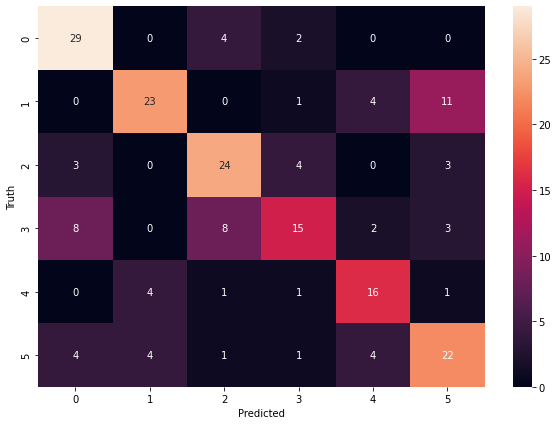

In [29]:
#confusion matrix
cm = confusion_matrix(actual, predictions)
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

## Live Demo

In [30]:
#saving the model
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


In [31]:
model = load_model('C:/Users/Jawher/Desktop/jihed/model.h5')
print("model loaded")
model.summary()

model loaded
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 250, 128)          1408      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 41, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 41, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6, 128)           0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 128)

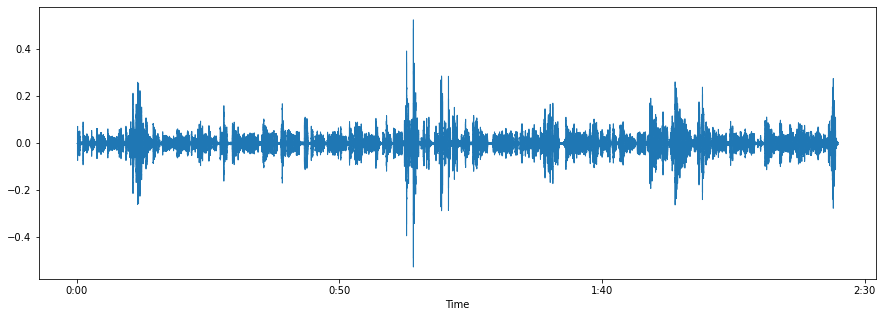

In [32]:
data, sampling_rate = librosa.load('C:/Users/Jawher/Desktop/jihed/Conversation Sound.wav')
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

In [33]:
X, sample_rate = librosa.load('C:/Users/Jawher/Desktop/jihed/Conversation Sound.wav', res_type='kaiser_fast',duration=7,sr=44000,offset=0.5)
sample_rate = np.array(sample_rate)
#extracting features
spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
db_spec = librosa.power_to_db(spectrogram)
log_spectrogram = np.mean(db_spec, axis = 0)
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
mfcc=np.mean(mfcc,axis=0)
zcr = librosa.feature.zero_crossing_rate(y=X)
zcr = np.mean(zcr, axis= 0)
#converting features to numpy arrays
ls = np.array(log_spectrogram )
zcr1=np.array(zcr )
mf=np.array(mfcc)
#appending all arrays into a single one
live=np.append(ls,zcr1)
live=np.append(live,mf)

In [34]:
# NORMALIZE DATA
mean = np.mean(live, axis=0)
std = np.std(live, axis=0)
livedata = (live - mean)/std
# TURN DATA INTO ARRAYS FOR KERAS
livedata = np.array(livedata)
#resizing data to fit the model
livedata=np.resize(livedata,259)

In [35]:
#putting the data inside a dataframe then making it  3d to fit the tensor
livedf2 = livedata
livedf2= pd.DataFrame(data=livedf2)
livedf2 = livedf2.stack().to_frame().T
twodim= np.expand_dims(livedf2, axis=2)

In [68]:
#live prediction in detail
livepreds = model.predict(twodim, 
                         batch_size=128, 
                         verbose=1)


1/1 [==============================] - 1s 965ms/step


In [69]:
#live prediction
livepreds=livepreds.argmax(axis=1)
liveabc = livepreds.astype(int).flatten()
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['calm'], dtype=object)

### SVM 3D array

In [91]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(df_combined, test_size=0.2, random_state=0,
                               stratify=df_combined[['gender','actor']])

X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)

X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2].drop(columns=['gender'])
print(X_test.shape)
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# RESHAPE TO INCLUDE 3D TENSOR
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

(809, 259)
(203, 259)


In [71]:
from sklearn import svm
nsamples, nx, ny = X_train.shape
X_train1 = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test1 = X_test.reshape((nsamples,nx*ny))

In [72]:
from sklearn import svm
SVM = svm.SVC(C=10,gamma=0.0001, kernel='rbf')



In [73]:
SVM.fit(X_train1, y_train)

SVC(C=10, gamma=0.0001)

In [75]:
svm_predictions = SVM.predict(X_test1)
print(svm_predictions)

['calm' 'happy' 'angry' 'fear' 'fear' 'happy' 'calm' 'calm' 'angry' 'fear'
 'calm' 'happy' 'neutral' 'angry' 'neutral' 'happy' 'neutral' 'sad'
 'neutral' 'angry' 'calm' 'angry' 'angry' 'sad' 'fear' 'happy' 'sad'
 'happy' 'fear' 'neutral' 'happy' 'happy' 'happy' 'happy' 'happy' 'happy'
 'angry' 'angry' 'happy' 'angry' 'fear' 'sad' 'angry' 'fear' 'fear' 'calm'
 'fear' 'happy' 'angry' 'angry' 'angry' 'sad' 'calm' 'fear' 'calm' 'sad'
 'fear' 'sad' 'sad' 'neutral' 'fear' 'angry' 'calm' 'calm' 'sad' 'happy'
 'fear' 'happy' 'angry' 'happy' 'happy' 'sad' 'sad' 'sad' 'angry' 'angry'
 'fear' 'happy' 'angry' 'sad' 'calm' 'happy' 'sad' 'happy' 'happy' 'fear'
 'calm' 'calm' 'neutral' 'sad' 'calm' 'fear' 'calm' 'fear' 'calm' 'calm'
 'angry' 'happy' 'sad' 'angry' 'calm' 'angry' 'calm' 'angry' 'angry'
 'angry' 'angry' 'neutral' 'calm' 'happy' 'neutral' 'happy' 'angry' 'sad'
 'calm' 'calm' 'happy' 'sad' 'sad' 'neutral' 'fear' 'angry' 'happy' 'fear'
 'neutral' 'angry' 'angry' 'calm' 'happy' 'neutral' 'c

In [76]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, svm_predictions))

0.6354679802955665


In [77]:
#testing the SVM model on our test data set
from sklearn.metrics import confusion_matrix
SVM_predictions=SVM.predict(X_test1)

cm=confusion_matrix(y_test,SVM_predictions)


Text(69.0, 0.5, 'Truth')

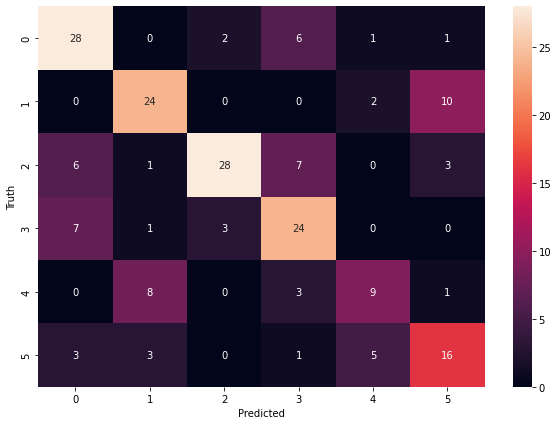

In [78]:
#confusion matrix
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

### ANN 2D


In [87]:
from tensorflow import keras
from tensorflow.keras import layers
NAME = "{}-Model-{}".format("ANN", int(time.time()))
print(NAME)
ann = tf.keras.models.Sequential()
 #Adding First Hidden Layer
ann.add(tf.keras.layers.Dense(units=128,kernel_regularizer=keras.regularizers.l2(1e-4),activation="relu"))
ann.add(layers.Dropout(0.4)) 
#Adding Second Hidden Layer
ann.add(tf.keras.layers.Dense(units=128,kernel_regularizer=keras.regularizers.l2(1e-4),activation="relu"))
ann.add(layers.Dropout(0.4)) 
#Adding Output Layer
ann.add(tf.keras.layers.Dense(units=6,activation="softmax"))
#Compiling ANN
tensorboard = TensorBoard(log_dir="ANN/{}".format(NAME))
ann.compile(optimizer="adam",loss="CategoricalCrossentropy",metrics=['accuracy'])
#Fitting ANN

print(y_train.shape)
print(X_train.shape)

ann.fit(X_train, y_train,batch_size=32, epochs=40, validation_data=(X_test, y_test),callbacks=[tensorboard])

ANN-Model-1653532080
(809, 6)
(809, 259)
Epoch 1/40
26/26 [==============================] - 16s 188ms/step - loss: 1.9145 - accuracy: 0.2583 - val_loss: 1.5162 - val_accuracy: 0.3350
Epoch 2/40
26/26 [==============================] - 2s 79ms/step - loss: 1.6277 - accuracy: 0.3486 - val_loss: 1.4264 - val_accuracy: 0.4089
Epoch 3/40
26/26 [==============================] - 1s 51ms/step - loss: 1.4965 - accuracy: 0.3956 - val_loss: 1.4026 - val_accuracy: 0.4187
Epoch 4/40
26/26 [==============================] - 2s 84ms/step - loss: 1.4082 - accuracy: 0.4487 - val_loss: 1.3630 - val_accuracy: 0.4631
Epoch 5/40
26/26 [==============================] - 2s 61ms/step - loss: 1.4661 - accuracy: 0.4054 - val_loss: 1.3341 - val_accuracy: 0.4532
Epoch 6/40
26/26 [==============================] - 1s 57ms/step - loss: 1.3993 - accuracy: 0.4215 - val_loss: 1.3419 - val_accuracy: 0.4532
Epoch 7/40
26/26 [==============================] - 2s 62ms/step - loss: 1.3404 - accuracy: 0.4648 - val_loss: 

In [88]:
from sklearn.metrics import accuracy_score
ann_predictions=ann.predict(X_test)
ann_predictions=(ann_predictions > 0.5)
#results
print(accuracy_score(y_test, ann_predictions))

7/7 [==============================] - 1s 5ms/step
0.4236453201970443


In [89]:
#testing the ANN model on our test data set
from sklearn.metrics import confusion_matrix
ann_predictions=ann.predict(X_test)
ann_predictions = (ann_predictions > 0.5) 
cm1=confusion_matrix(y_test.argmax(axis=1),ann_predictions.argmax(axis=1))


7/7 [==============================] - 1s 3ms/step


Text(69.0, 0.5, 'Truth')

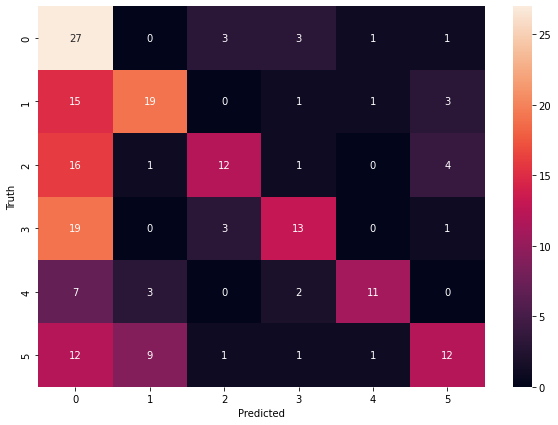

In [90]:
#confusion matrix
plt.figure(figsize=(10,7))
sn.heatmap(cm1, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

### NB 3D array

In [92]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_test)
#y_train= le.transform(y_train)
y_test= le.transform(y_test)
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
X=X_train1
XT=X_test1
classifier = classifier.fit(X, y_train)
nb_predictions  =  classifier.predict(XT)
#results
print(accuracy_score(y_test, nb_predictions))

0.0


In [86]:
print(y_test)


[1 3 0 2 2 3 1 1 0 2 1 4 4 2 4 3 4 1 4 0 1 5 0 1 0 2 5 3 2 5 0 2 3 3 5 3 3
 0 2 0 2 5 0 2 2 1 2 0 0 3 0 5 4 2 4 2 2 5 5 5 2 0 1 1 1 3 2 2 0 3 4 5 2 1
 2 3 2 0 0 5 1 3 5 3 4 2 5 5 4 1 2 3 4 2 1 1 2 3 1 3 4 0 1 0 0 0 5 1 1 2 5
 0 3 1 1 4 0 1 0 1 2 0 2 2 5 0 0 1 3 4 5 4 2 3 4 1 2 1 0 3 0 2 5 1 1 0 1 0
 0 0 2 0 1 2 2 5 4 4 5 2 4 3 0 2 5 5 2 0 2 1 3 5 3 1 2 2 0 3 2 2 3 3 3 5 1
 5 1 3 5 2 3 1 3 0 0 3 5 3 4 3 3 2 4]


In [91]:
print(nb_predictions)

['happy' 'happy' 'angry' 'angry' 'fear' 'angry' 'calm' 'calm' 'angry'
 'neutral' 'calm' 'neutral' 'happy' 'angry' 'calm' 'happy' 'neutral'
 'calm' 'calm' 'angry' 'calm' 'fear' 'angry' 'calm' 'angry' 'happy' 'sad'
 'happy' 'angry' 'neutral' 'happy' 'happy' 'fear' 'happy' 'happy' 'happy'
 'angry' 'angry' 'fear' 'angry' 'happy' 'happy' 'angry' 'fear' 'fear'
 'calm' 'angry' 'angry' 'angry' 'angry' 'angry' 'calm' 'happy' 'fear'
 'calm' 'calm' 'angry' 'calm' 'calm' 'neutral' 'angry' 'angry' 'sad'
 'calm' 'happy' 'angry' 'happy' 'neutral' 'angry' 'happy' 'happy' 'happy'
 'calm' 'neutral' 'angry' 'angry' 'angry' 'sad' 'angry' 'happy' 'happy'
 'happy' 'sad' 'angry' 'happy' 'angry' 'calm' 'calm' 'neutral' 'calm'
 'calm' 'happy' 'neutral' 'fear' 'calm' 'calm' 'fear' 'happy' 'calm'
 'angry' 'calm' 'fear' 'neutral' 'angry' 'angry' 'angry' 'angry' 'neutral'
 'calm' 'happy' 'neutral' 'happy' 'angry' 'sad' 'calm' 'calm' 'angry'
 'neutral' 'happy' 'neutral' 'angry' 'angry' 'happy' 'neutral' 'calm'
 'an

# RF 2D

In [100]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train, y_train)
rf.score(X_test,y_test)


0.27582486173380083

In [101]:
#testing the RF model on our test data set
from sklearn.metrics import confusion_matrix
rf_predictions=rf.predict(X_test)
rf_predictions = (rf_predictions > 0.5) 
cm=confusion_matrix(y_test.argmax(axis=1),rf_predictions.argmax(axis=1))


Text(69.0, 0.5, 'Truth')

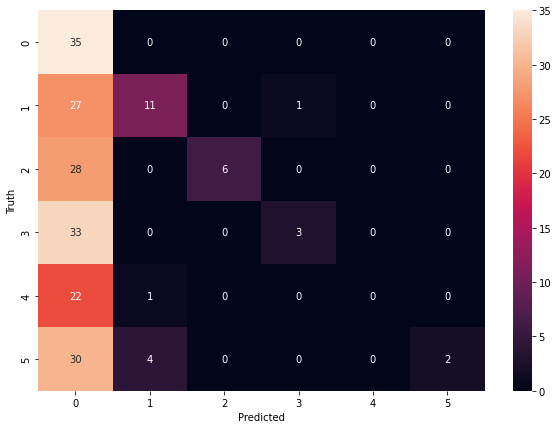

In [102]:
#confusion matrix
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

### LSTM  2D

In [105]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras  import layers
from tensorflow.keras.layers import Dense, Dropout, LSTM
NAME = "{}-Model-{}".format(LSTM, int(time.time()))
model = Sequential()
model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=True), 
                        input_shape=(X_train.shape[1],1)))
model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=True)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(128))
model.add(layers.ELU())
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(6, activation='softmax'))
tensorboard = TensorBoard(log_dir=r"C:.\Users\21652\Desktop\jihed\LSTM")

opt=tf.keras.optimizers.Adam(0.001,decay=1e-6)

model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model.fit(X_train, y_train,batch_size=32, epochs=20, validation_data=(X_test, y_test),callbacks=[tensorboard])

Epoch 1/20
26/26 [==============================] - 249s 8s/step - loss: 1.5036 - accuracy: 0.3486 - val_loss: 1.4873 - val_accuracy: 0.4039
Epoch 2/20
26/26 [==============================] - 203s 8s/step - loss: 1.3774 - accuracy: 0.4413 - val_loss: 1.4876 - val_accuracy: 0.3350
Epoch 3/20
26/26 [==============================] - 210s 8s/step - loss: 1.3224 - accuracy: 0.4635 - val_loss: 1.3704 - val_accuracy: 0.4680
Epoch 4/20
26/26 [==============================] - 211s 8s/step - loss: 1.2797 - accuracy: 0.4784 - val_loss: 1.3153 - val_accuracy: 0.4828
Epoch 5/20
26/26 [==============================] - 204s 8s/step - loss: 1.2392 - accuracy: 0.4932 - val_loss: 1.3502 - val_accuracy: 0.4384
Epoch 6/20
26/26 [==============================] - 214s 8s/step - loss: 1.2088 - accuracy: 0.5253 - val_loss: 1.3203 - val_accuracy: 0.4581
Epoch 7/20
26/26 [==============================] - 221s 9s/step - loss: 1.1572 - accuracy: 0.5266 - val_loss: 1.3155 - val_accuracy: 0.4581
Epoch 8/20
26

In [196]:
#testing the LSTM model on our test data set
from sklearn.metrics import confusion_matrix
model_predictions=model.predict(X_test)
model_predictions = (model_predictions > 0.5) 
cm=confusion_matrix(y_test.argmax(axis=1),model_predictions.argmax(axis=1))


7/7 [==============================] - 5s 554ms/step


Text(69.0, 0.5, 'Truth')

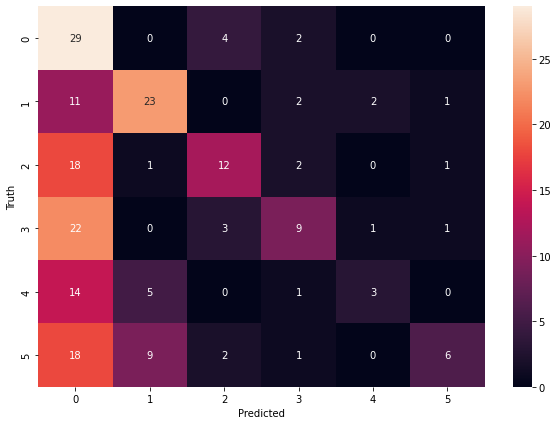

In [197]:
#confusion matrix
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')